
# <b>Tutorial 3: Basic data analysis</b>



## Learning Objectives:

In this session we will learn: 
1. to calculate and visualise annual and monthly means
2. to calculate and visualise seasonal means
3. to calculate mean differences (anomalies)

## Contents

1. [Calculate annual and monthly mean](#annual)
2. [Calculate seasonal means](#season)
3. [Calculating differences (anomalies)](#percent)
4. [Exercises](#exercise)

<div class="alert alert-block alert-warning">
<b>Prerequisites</b> <br> 
- Basic programming skills in python<br>
- Familiarity with python libraries Iris, Numpy and Matplotlib<br>
- Basic understanding of climate data<br>
- Tutorials 1 and 2
</div>

___

## 1. Calculating annual and monthly mean<a id='annual'></a>


## 1.1 Import libraries <a id='explore'></a>
Import the necessary libraries. Current datasets are in zarr format, we need zarr and xarray libraries to access the data

In [2]:
import numpy as np
import xarray as xr
import zarr
import iris
import os
from cssp_utils import zarr_reader
from catnip.preparation import extract_rot_cube, add_bounds
from xarray_iris_coord_system import XarrayIrisCoordSystem as xics
xi = xics()
xr.set_options(display_style='text') # Work around for AML bug that won't display HTML output.

### 1.2 Set up authentication for the Azure blob store

The data for this course is held online in an Azure Blob Storage Service. To access this we use a SAS (shared access signature).  You should have been given the credentials for this service before the course, but if not please ask your instructor. We use the getpass module here to avoid putting the token into the public domain. Run the cell below and in the box enter your SAS and press return. This will store the password in the variable SAS.

In [3]:
import getpass
# SAS WITHOUT leading '?'
SAS = getpass.getpass()

 ····················································································


We now use the Zarr library to connect to this storage. This is a little like opening a file on a local file system but works without downloading the data. This makes use of the Azure Blob Storage service. The zarr.ABStore method returns a zarr.storage.ABSStore object which we can now use to access the Zarr data in the same way we would use a local file. If you have a Zarr file on a local file system you could skip this step and instead just use the path to the Zarr data below when opening the dataset.

In [4]:
store = zarr.ABSStore(container='metoffice-20cr-ds', prefix='monthly/', account_name="metdatasa", blob_service_kwargs={"sas_token":SAS})
type(store)

zarr.storage.ABSStore

### 1.3 Read monthly data
A Dataset consists of coordinates and data variables. Let's use the xarray's **open_zarr()** method to read all our zarr data into a dataset object and display it's metadata.

In [5]:
# use the open_zarr() method to read in the whole dataset metadata
dataset = xr.open_zarr(store)
# print out the metadata
dataset

<xarray.Dataset>
Dimensions:                                    (grid_latitude: 203, grid_latitude_1: 202, grid_longitude: 270, grid_longitude_1: 270, pressure: 17, time: 1920)
Coordinates:
  * grid_latitude                              (grid_latitude) float32 21.119...
  * grid_latitude_1                            (grid_latitude_1) float32 21.0...
  * grid_longitude                             (grid_longitude) float32 325.2...
  * grid_longitude_1                           (grid_longitude_1) float32 325...
  * pressure                                   (pressure) float32 10.0 ... 10...
  * time                                       (time) datetime64[ns] 1851-01-...
Data variables:
    air_pressure_at_sea_level                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    air_temperature_at_pressure_mean           (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 203, 270), meta=np.ndarray>
    air_temperature_maximum                    (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    air_temperature_mean                       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    air_temperature_minimum                    (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    cloud_area_fraction                        (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    geopotential_height                        (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 203, 270), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure        (time, pressure, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 1, 202, 270), meta=np.ndarray>
    precipitation_flux                         (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    relative_humidity_at_pressure_mean         (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 203, 270), meta=np.ndarray>
    relative_humidity_mean                     (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    specific_humidity                          (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_air_pressure                       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_downwelling_longwave_flux_in_air   (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_temperature                        (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    x_wind_at_pressure_mean                    (time, pressure, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 1, 202, 270), meta=np.ndarray>
    x_wind_mean                                (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 202, 270), meta=np.ndarray>
    y_wind_at_pressure_mean                    (time, pressure, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 1, 202, 270), meta=np.ndarray>
    y_wind_mean                                (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 202, 270), meta=np.ndarray>

Convert dataset into iris cubelist

In [6]:
# create an empty list to hold the iris cubes
cubelist = iris.cube.CubeList([])

# use the DataSet.apply() to convert the dataset to Iris Cublelist
dataset.apply(lambda da: cubelist.append(xi.to_iris(da)))

# print out the cubelist.
cubelist

[<iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; pressure: 17; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of cloud_area_fraction / (unknown) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of geopotential_height / (m) (time: 1920; pressure: 17; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of lagrangian_tendency_of_air_pressure / (Pa s-1) (time: 1920; pressure: 17; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of relative_humidity / (%) (time: 1920; pressure: 17; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of relative_humidity / (%) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of specific_humidity / (unknown) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_air_pressure / (Pa) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_downwelling_longwave_flux_in_air / (W m-2) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_downwelling_shortwave_flux_in_air / (W m-2) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of x_wind / (m s-1) (time: 1920; pressure: 17; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of x_wind / (m s-1) (time: 1920; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of y_wind / (m s-1) (time: 1920; pressure: 17; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of y_wind / (m s-1) (time: 1920; grid_latitude: 202; grid_longitude: 270)>]

---

### 1.4 Calculating annual cycle

Here we calculate annual mean, maximum and minimum air_temperature over the Shanghai region from 1981 to 2010. 

We will first need to extract the required variables, extract the Shanghai region and constrain by time period. 

In [7]:
# extract air_temperature
air_temp = cubelist.extract('air_temperature')

# extracting maximum air temperature
cons = iris.Constraint(cube_func=lambda c: ('ukmo__process_flags' in c.attributes) and (c.attributes['ukmo__process_flags'][0].split(' ')[0] == 'Maximum'))
air_temp_max = air_temp.extract_strict(cons)

# extracting mainimum air temperature
cons = iris.Constraint(cube_func=lambda c: ('ukmo__process_flags' in c.attributes) and (c.attributes['ukmo__process_flags'][0].split(' ')[0] == 'Minimum'))
air_temp_min = air_temp.extract_strict(cons)

# extracting mean air temperature
cons = iris.Constraint(cube_func=lambda c: (len(c.cell_methods) > 0) and (c.cell_methods[0].method == 'mean') and c.cell_methods[0].intervals[0] == '1 hour')
air_temp_mean = air_temp.extract_strict(cons)

In [8]:
# defining Shangai region coords
min_lat=29.0
max_lat=32.0
min_lon=118.0
max_lon=123.0


# extract data for the the Shanghai region using extract_rot_cube() function
max_cube = extract_rot_cube(air_temp_max, min_lat, min_lon, max_lat, max_lon)
min_cube = extract_rot_cube(air_temp_min, min_lat, min_lon, max_lat, max_lon)
mean_cube = extract_rot_cube(air_temp_mean, min_lat, min_lon, max_lat, max_lon)

In [9]:
# define start and end year for our time constraint
start_time = 1981
end_time = 2010

# define the time constraint
time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)

# load the data into cubes applying the time constraint
max_cube = max_cube.extract(time_constraint)
min_cube = min_cube.extract(time_constraint)
mean_cube = mean_cube.extract(time_constraint)

<div class="alert alert-block alert-info">
<b>Note:</b>The <b>CATNIP</b> library function <b>preparation.add_time_coord_cats</b> adds a range of numeric coordinate categorisations to the cube. For more details see the <a href="https://metoffice.github.io/CATNIP/tools.html#preparation-module">documentation</a>
</div>

We have got required cubes. Now we can add categorical coordinates to such as *year*  to the time dimension in our cubes using the CATNIP **preparation.add_time_coord_cats** function.

In [10]:
# load CATNIP's add_time_coord_cats method
from catnip.preparation import add_time_coord_cats

# Add other dimension coordinates
max_cube = add_time_coord_cats(max_cube)
min_cube = add_time_coord_cats(min_cube)
mean_cube = add_time_coord_cats(mean_cube)

Print the *max_cube* and inspect the categorical coordinates that have been added to the time coordinate of our cube.

In [11]:
# printing the max_cube. Note the addtional coordinates under the Auxiliary coordinates
max_cube

Air Temperature (K),time,grid_latitude,grid_longitude
Shape,360,16,21
Dimension coordinates,,,
time,x,-,-
grid_latitude,-,x,-
grid_longitude,-,-,x
Auxiliary coordinates,,,
day_of_month,x,-,-
day_of_year,x,-,-
month,x,-,-
month_number,x,-,-


We can see that **add_time_coord_cats** has added a few auxiliary coordinates including the *year* coordinate to the *time* dimension.

Now we can calculate maximum, minimum and mean values over the *year* coordinate using **aggregated_by** method.

In [12]:
# Calculate yearly max, min and mean values
yearly_max = max_cube.aggregated_by(['year'], iris.analysis.MAX)
yearly_min = min_cube.aggregated_by(['year'], iris.analysis.MIN)
yearly_mean = mean_cube.aggregated_by(['year'], iris.analysis.MEAN)

In [13]:
# Collapse longitude and latitude to get a timeseries
yearly_max = yearly_max.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MAX)
yearly_min = yearly_min.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MIN)
yearly_mean = yearly_mean.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MEAN)

/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'grid_latitude'.
  warnings.warn(msg.format(self.name()))
/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'grid_longitude'.
  warnings.warn(msg.format(self.name()))
/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1406: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1406: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-conti

Print the *year* coordinate of max cube to see if we have the correct years for our constraint time period.

In [14]:
print(yearly_max.coord('year').points)

[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010]


### 1.5 Calculating mean annual cycle

We can calculate the mean annual cycle for precipitation_flux data over the Shanghai region for 1981-2010 (30 years) by averaging together each month(so we average all January data to get the mean for January).

In [15]:
# extract the precipitation_flux data into an iris cube from the cubelist
pflx = cubelist.extract_strict('precipitation_flux')

In [17]:
min_lat=29.0
max_lat=32.0
min_lon=118.0
max_lon=123.0

# extract data for the the Shanghai region using extract_rot_cube() function
pflx_ext = extract_rot_cube(pflx, min_lat, min_lon, max_lat, max_lon)
pflx_ext

<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 1920; grid_latitude: 16; grid_longitude: 21)>

Next extracting time constraint

In [18]:
# Extracting time constraint
start_time = 1981
end_time = 2010
time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)
subcube = pflx_ext.extract(time_constraint)
subcube

<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 360; grid_latitude: 16; grid_longitude: 21)>

In [19]:
# remove auxiliary coordinates
subcube.remove_coord("latitude")
subcube.remove_coord("longitude")

we can use the **add_time_coord_cats** method and add categorical coordinates such as *month* to the *time* dimension to our cube.

In [20]:
# add the time categorical coordinate to cube
subcube = add_time_coord_cats(subcube)

In [21]:
# Create mean annual cycle
monthly_mean = subcube.aggregated_by(['month_number'], iris.analysis.MEAN)

In [22]:
monthly_mean = add_bounds(monthly_mean, ['grid_latitude','grid_longitude'])

grid_latitude bounds added
grid_longitude bounds added


We can calculate the area weight using **iris.analysis.cartography.area_weights** so that we weight the average to account for the fact that the areas of grid cells are variable.

In [23]:
import iris.analysis.cartography
#calculate the area weight
grid_areas = iris.analysis.cartography.area_weights(monthly_mean)

In [24]:
# Calculate area averaged monthly mean rainfall
monthly_mean = monthly_mean.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MEAN, weights=grid_areas)

### 1.6 Visualising yearly and monthly means

Let's now visualise yearly mean, max, min data for the air temperature and monthly mean data for the precipitation_flux.

In [25]:
# we first need to load libraries for plotting 
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt

Visualise yearly max, min and mean data for *air_temperature*.

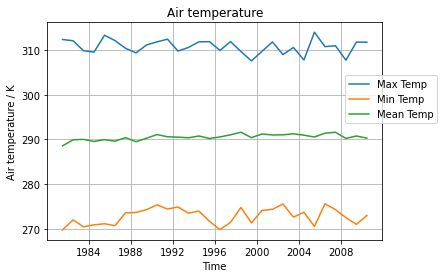

In [26]:
# plot the timeseries for yearly max, min and mean data
ax1 = qplt.plot(yearly_max, label = 'Max Temp')
ax2 = qplt.plot(yearly_min, label = 'Min Temp')
ax3 = qplt.plot(yearly_mean, label = 'Mean Temp')
plt.legend(bbox_to_anchor=(1.18, 0.78))
plt.grid()
plt.show()


Let's visualise monthly precipitation mean over the thirty years (1980-2010).

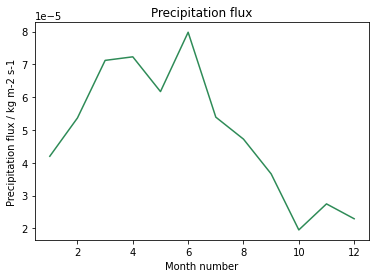

In [27]:
qplt.plot(monthly_mean.coord('month_number'), monthly_mean,color='seagreen')
plt.show()

<div class="alert alert-block alert-success">
    <b>Task:</b><br><ul>
        <li>Calculate and visualise the monthly mean over Tibetan region from 1981 to 2010. Create the monthly mean with month names</li>
        <li>Coordinates of Tibetan region: Latitude = [26 36], Longitude = [77 104]</li>
    </ul>
</div>


In [28]:
# extracting mean air temperature
cons = iris.Constraint(cube_func=lambda c: (len(c.cell_methods) > 0) and (c.cell_methods[0].method == 'mean') and c.cell_methods[0].intervals[0] == '1 hour')
air_temp_mean = air_temp.extract_strict(cons)

# defining Tibetan region coords
min_lat=26.0
max_lat=36.0
min_lon=77.0
max_lon=104.0

# Extract the tibetan region
air_temp_mean = extract_rot_cube(air_temp_mean, min_lat, min_lon, max_lat, max_lon)

# Time extraction
start_time = 1981
end_time = 2010
time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)
air_temp_mean = air_temp_mean.extract(time_constraint)

# remove auxiliary coordinates
air_temp_mean.remove_coord("latitude")
air_temp_mean.remove_coord("longitude")

# add the time categorical coordinate to cube
air_temp_mean = add_time_coord_cats(air_temp_mean)


# Calculating monthly mean
monthly_mean = air_temp_mean.aggregated_by(['month'], iris.analysis.MEAN)

# adding bounds
monthly_mean = add_bounds(monthly_mean, ['grid_latitude','grid_longitude'])

#calculate the area weight
grid_areas = iris.analysis.cartography.area_weights(monthly_mean)

# Calculate area averaged monthly mean rainfall
monthly_mean = monthly_mean.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MEAN, weights=grid_areas)

grid_latitude bounds added
grid_longitude bounds added


/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/plot.py:245: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  formatter = mpl_ticker.IndexFormatter(ticks)


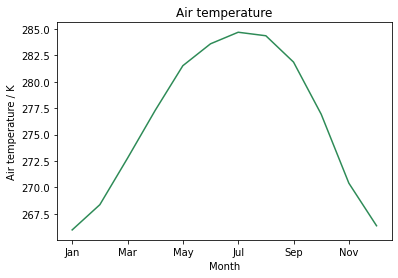

In [29]:
# Visualizing the monthly mean with month names on x-axis
qplt.plot(monthly_mean.coord('month'), monthly_mean,color='seagreen')
plt.show()

___

## 2. Calculating seasonal means<a id='season'></a>

### 2.1 Calculating seasonal means: djf, mam, jja and son

Calculate mean wind speed and wind direction from 1981 to 2010 for different seasons over the entire domain.

First we need to calculate wind speed and wind direction. In previous tutorial, we calculated the wind speed using hard coded simple arithmetic operations. In this tutorial, we will use catnip's **windspeed** and **wind_direction** methods.


In [30]:
# define constraints for x_wind and y_wind data
xcons = iris.Constraint(cube_func=lambda c: c.standard_name == 'x_wind' and ('pressure' not in [coord.name() for coord in c.coords()]))
ycons = iris.Constraint(cube_func=lambda c: c.standard_name == 'y_wind' and ('pressure' not in [coord.name() for coord in c.coords()]))

# apply the constraint and load the x_wind and y_wind data
u = cubelist.extract_strict(xcons)
v = cubelist.extract_strict(ycons)

In [31]:
# define time constraint
start_time = 1981
end_time = 2010
cons = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)
u = u.extract(time_constraint)
v = v.extract(time_constraint)

We can now import and use catnip's **windspeed** and **wind_direction** methods

In [32]:
# import catnip methods
from catnip.analysis import windspeed
from catnip.analysis import wind_direction

In [33]:
# calculate windspeed and wind direction
wind_speed_cube = windspeed(u,v)
wind_direction_cube = wind_direction(u,v)

data is on rotated coord system, un-rotating . . .


Add coordinates and extract data for different seasons

In [34]:
wind_speed_cube = add_time_coord_cats(wind_speed_cube)
wind_direction_cube = add_time_coord_cats(wind_direction_cube)

In [37]:
# Extract the windspeed data for all four seasons
wndspd_djf = wind_speed_cube.extract(iris.Constraint(season='djf'))
wndspd_mam = wind_speed_cube.extract(iris.Constraint(season='mam'))
wndspd_jja = wind_speed_cube.extract(iris.Constraint(season='jja'))
wndspd_son = wind_speed_cube.extract(iris.Constraint(season='son'))

# Extract the wind direction data for the all four season 
wnddir_djf = wind_direction_cube.extract(iris.Constraint(season='djf'))
wnddir_mam = wind_direction_cube.extract(iris.Constraint(season='mam'))
wnddir_jja = wind_direction_cube.extract(iris.Constraint(season='jja'))
wnddir_son = wind_direction_cube.extract(iris.Constraint(season='son'))

Calculate seasonal means

In [38]:
# calculate the windspeed mean over the seasons
wspd_djf_mean = wndspd_djf.aggregated_by(['season'], iris.analysis.MEAN)
wspd_mam_mean = wndspd_mam.aggregated_by(['season'], iris.analysis.MEAN)
wspd_jja_mean = wndspd_jja.aggregated_by(['season'], iris.analysis.MEAN)
wspd_son_mean = wndspd_son.aggregated_by(['season'], iris.analysis.MEAN)

# calculate the wind direction mean over the seasons
wndir_djf_mean = wnddir_djf.aggregated_by(['season'], iris.analysis.MEAN)
wndir_mam_mean = wnddir_mam.aggregated_by(['season'], iris.analysis.MEAN)
wndir_jja_mean = wnddir_jja.aggregated_by(['season'], iris.analysis.MEAN)
wndir_son_mean = wnddir_son.aggregated_by(['season'], iris.analysis.MEAN)

We can now visualise seasonal means

In [39]:
# we first need to load libraries for plotting 
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt

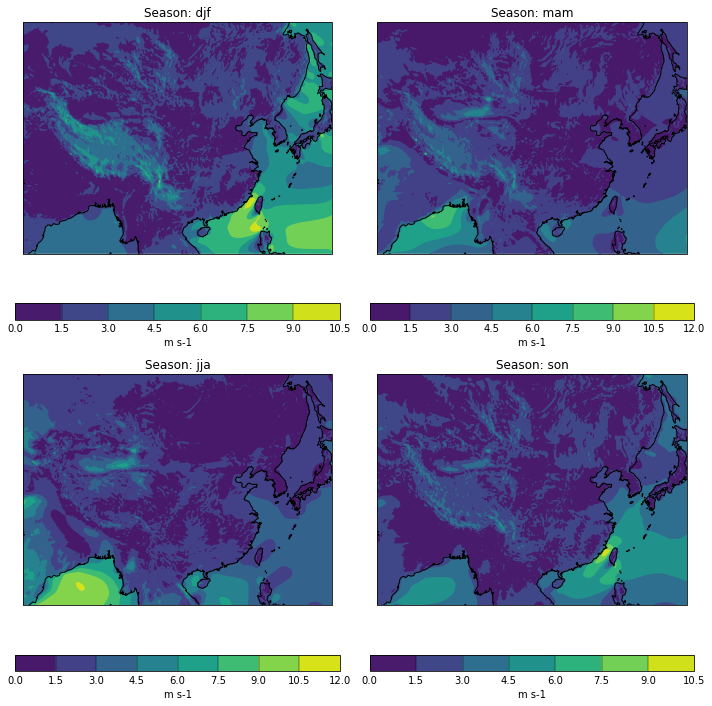

In [40]:
# list of seasonal cubes to loop through
seasonal_cubes = [wspd_djf_mean, wspd_mam_mean, wspd_jja_mean, wspd_son_mean]

# set a figure big enough to hold the subplots
plt.figure(figsize=(10, 10))

# loop through the seaonal cube list and plot the data
for i in range(len(seasonal_cubes)):    
   
    plt.subplot(2, 2, i+1)
    # plot the windspeed at the first timestep 
    qplt.contourf(seasonal_cubes[i][0,:,:])
    # add some coastlines for context
    plt.gca().coastlines()    
    # get the season name from the coordinate
    season = seasonal_cubes[i].coord('season').points[0]
    # add the name as plot's title
    plt.title('Season: '+ season)
    plt.tight_layout()
    
plt.show()

<div class="alert alert-block alert-success">
    <b>Task:</b><br><ul>
        <li>Calculate and visualise the seasonal mean of <b>surface temperature</b> over Tibatan region from 1981 to 2010.</li>
        <li>Coordinates of Tibetan region: Latitude = [26 36], Longitude = [77 104]</li>
    </ul>
</div>

In [41]:
# Extract surface temperature
sft = cubelist.extract_strict('surface_temperature')

# defining Tibetan region coords
min_lat=26.0
max_lat=36.0
min_lon=77.0
max_lon=104.0

# Extract the tibetan region
sft = extract_rot_cube(sft, min_lat, min_lon, max_lat, max_lon)

# Extract time
start_time = 1981
end_time = 2010
cons = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)
sft = sft.extract(time_constraint)

sft = add_time_coord_cats(sft)

# Extract the surface temperature for all four seasons
sft_djf = sft.extract(iris.Constraint(season='djf'))
sft_mam = sft.extract(iris.Constraint(season='mam'))
sft_jja = sft.extract(iris.Constraint(season='jja'))
sft_son = sft.extract(iris.Constraint(season='son'))

# calculate the mean over the seasons
sft_djf_mean = sft_djf.aggregated_by(['season'], iris.analysis.MEAN)
sft_mam_mean = sft_mam.aggregated_by(['season'], iris.analysis.MEAN)
sft_jja_mean = sft_jja.aggregated_by(['season'], iris.analysis.MEAN)
sft_son_mean = sft_son.aggregated_by(['season'], iris.analysis.MEAN)

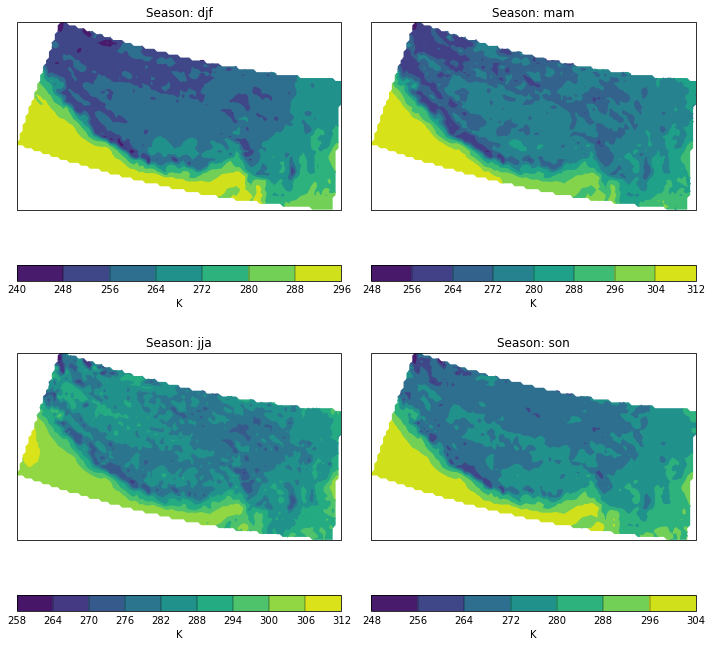

In [42]:
# Visualising seasonal means
# list of seasonal cubes to loop through
seasonal_cubes = [sft_djf_mean, sft_mam_mean, sft_jja_mean, sft_son_mean]


# set a figure big enough to hold the subplots
plt.figure(figsize=(10, 10))

# loop through the seaonal cube list and plot the data
for i in range(len(seasonal_cubes)):    
   
    plt.subplot(2, 2, i+1)
    # plot the windspeed at the first timestep 
    qplt.contourf(seasonal_cubes[i][0,:,:])
    # add some coastlines for context
    plt.gca().coastlines()    
    # get the season name from the coordinate
    season = seasonal_cubes[i].coord('season').points[0]
    # add the name as plot's title
    plt.title('Season: '+ season)
    plt.tight_layout()
    
plt.show()

___

## 3. Calculating differences<a id='percent'></a>

### 3.1 mean surface temperature diffference in winter season (dec, jan, feb)

We can find the difference of mean surface temperature between the past(1851-1880) and recent(1981-2010) 30 years periods.

First, we need to extract out desired data

In [43]:
# extract air_temperature
sft = cubelist.extract_strict('surface_temperature')

In [44]:
# constraints: two 30 years periods - past and presnet
cons1 = iris.Constraint(time=lambda cell: 1851 <= cell.point.year <= 1880)
cons2 = iris.Constraint(time=lambda cell: 1981 <= cell.point.year <= 2010)
past = sft.extract(cons1)
present = sft.extract(cons2)

In [45]:
# load catnip's add_time_coord_cats method
from catnip.preparation import add_time_coord_cats

# Add other dimension coordinates
past = add_time_coord_cats(past)
present = add_time_coord_cats(present)

# Extract the winter season 
past_djf = past.extract(iris.Constraint(season='djf'))
present_djf = present.extract(iris.Constraint(season='djf'))

# extract data for Shanghai region
past_djf = extract_rot_cube(past_djf, min_lat, min_lon, max_lat, max_lon)
present_djf = extract_rot_cube(present_djf, min_lat, min_lon, max_lat, max_lon)

# calculate 30 year mean of winter season
past_djf = past_djf.aggregated_by(['season'], iris.analysis.MEAN)
present_djf = present_djf.aggregated_by(['season'], iris.analysis.MEAN)

We have now got our cubes for different climatological periods. We now calcuate the difference by subtracting the past data form present using **iris.analysis.math.subtract** method.

In [46]:
djf_diff = iris.analysis.maths.subtract(present_djf, past_djf)
djf_diff.rename('surface temperature difference: Winter')
past_djf.rename('surface temperature past climate: Winter 1851-1880 ')
present_djf.rename('surface temperature present climate: Winter 1981-2010 ')

In [47]:
# add bounds to the cubes 
past_djf = add_bounds(past_djf, ['grid_latitude','grid_longitude'])
present_djf = add_bounds(present_djf, ['grid_latitude','grid_longitude'])
djf_diff = add_bounds(djf_diff, ['grid_latitude','grid_longitude'])

grid_latitude bounds added
grid_longitude bounds added
grid_latitude bounds added
grid_longitude bounds added
grid_latitude bounds added
grid_longitude bounds added


</pre>
<div class="alert alert-block alert-info">
<b>Note:</b> iris.analysis.math provides a range of mathematical and statistical operations. See the <a href="https://scitools.org.uk/iris/docs/v1.9.1/iris/iris/analysis/maths.html">documentation for more information</a>

</div>

We can now visualise the difference

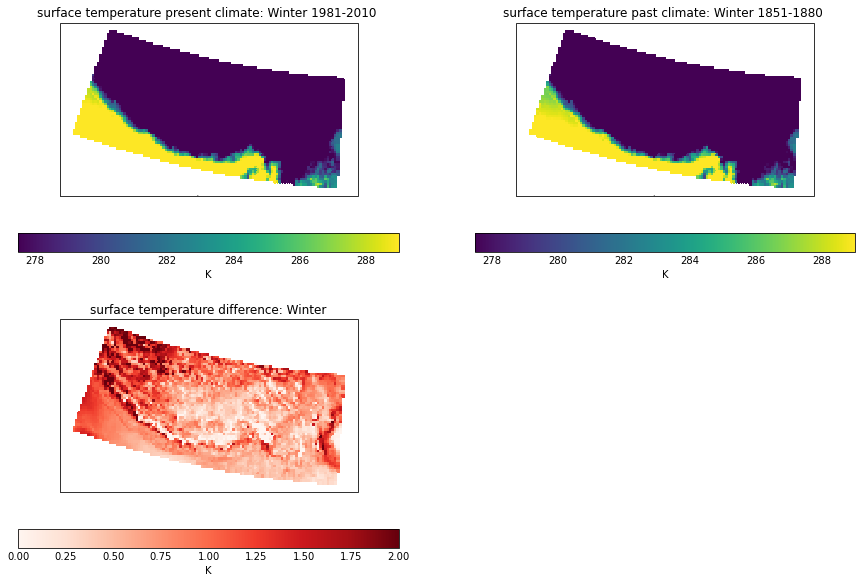

In [48]:
# list of our djf cubes and diff cube to loop through
seasonal_cubes = [present_djf, past_djf, djf_diff]
plt.figure(figsize=(15, 10))
# loop through the seaonal cube list and plot the data
for i in range(len(seasonal_cubes)):
    plt.subplot(2, 2, i+1)
    # plot the windspeed at the first timestep 
    if i==2:
        qplt.pcolormesh(seasonal_cubes[i][0,:,:],cmap=plt.cm.get_cmap('Reds'),vmin=0, vmax=2)
    else:
        qplt.pcolormesh(seasonal_cubes[i][0,:,:],vmin=277.5, vmax=289)
            
    # add some coastlines for context
    plt.gca().coastlines()    
    # get the season name from the coordinate
    season = seasonal_cubes[i].coord('season').points[0]
    # add the name as plot's title
    plt.title(seasonal_cubes[i].name())
    
    
plt.show()

### 3.2 Percentage difference in winter precipitaition 

We can also calculate the percentage difference. 

Let's calculate the change in mean precipitation from a past 30 year period (1851-1880) to the most recent 30 years (1981-2010)


In [49]:
# extract precipitation flux
pflx = cubelist.extract_strict('precipitation_flux')

# extract the time contraints 
cons1 = iris.Constraint(time=lambda cell: 1851 <= cell.point.year <= 1880)
cons2 = iris.Constraint(time=lambda cell: 1981 <= cell.point.year <= 2010)
past = pflx.extract(cons1)
present = pflx.extract(cons2)

# Add other dimension coordinates
past = add_time_coord_cats(past)
present = add_time_coord_cats(present)

# Extract the precipitation data for the winter season 
past_djf = past.extract(iris.Constraint(season='djf'))
present_djf = present.extract(iris.Constraint(season='djf'))

# extract data for Shanghai region
past_djf = extract_rot_cube(past_djf, min_lat, min_lon, max_lat, max_lon)
present_djf = extract_rot_cube(present_djf, min_lat, min_lon, max_lat, max_lon)

# calculate the means 
past_djf = past_djf.aggregated_by(['season'], iris.analysis.MEAN)
present_djf = present_djf.aggregated_by(['season'], iris.analysis.MEAN)

We can now calculate the difference using **subtract** function

In [50]:
djf_diff = iris.analysis.maths.subtract(present_djf, past_djf)
djf_diff.rename('precipitation flux difference: Winter')
past_djf.rename('precipitation flux past climate: Winter 1851-1880 ')
present_djf.rename('precipitation flux present climate: Winter 1981-2010 ')

In [51]:
# add bounds to the cubes 
past_djf = add_bounds(past_djf, ['grid_latitude','grid_longitude'])
present_djf = add_bounds(present_djf, ['grid_latitude','grid_longitude'])
djf_diff = add_bounds(djf_diff, ['grid_latitude','grid_longitude'])

grid_latitude bounds added
grid_longitude bounds added
grid_latitude bounds added
grid_longitude bounds added
grid_latitude bounds added
grid_longitude bounds added


To calcuate the percentage difference, we can use **analysis.maths.multiply** and **iris.analysis.maths.divide** to calculate percentage change

In [52]:
# Find the percentage change
pcent_change = iris.analysis.maths.multiply(iris.analysis.maths.divide(djf_diff, past_djf), 100)

# remember to change the title and units to reflect the data processing
pcent_change.rename('precipitation flux percent difference')
pcent_change.units = '%'

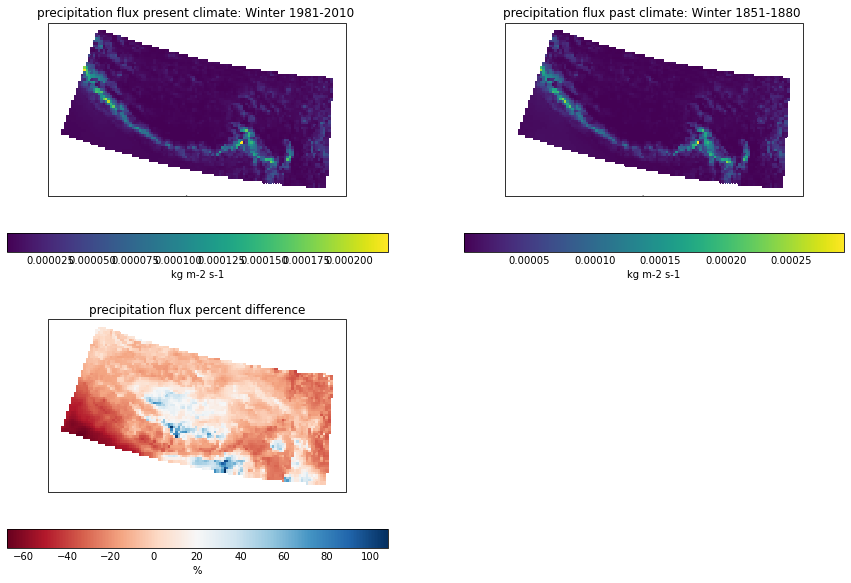

In [53]:
# using iris plot for better colour saturation!
import iris.plot as iplt

# list of our winter cubes and the diff cube to loop through for plotting
seasonal_cubes = [present_djf, past_djf, pcent_change]
plt.figure(figsize=(15, 10))
# loop through the seaonal cube list and plot the data
for i in range(len(seasonal_cubes)):
    plt.subplot(2, 2, i+1)
    # plot the windspeed at the first timestep 
    if i==2:
        qplt.pcolormesh(seasonal_cubes[i][0,:,:],cmap=plt.cm.get_cmap('RdBu'))
    else:
        qplt.pcolormesh(seasonal_cubes[i][0,:,:])
            
    #rcmp = iplt.pcolormesh(seasonal_cubes[i][0,:,:])
    #olorbar_axes = plt.gcf().add_axes()
    #colorbar = plt.colorbar(rcmp, colorbar_axes, orientation='horizontal')
    # add some coastlines for context
    plt.gca().coastlines()    
    # get the season name from the coordinate
    season = seasonal_cubes[i].coord('season').points[0]
    # add the name as plot's title
    plt.title(seasonal_cubes[i].name())
    
    
plt.show()

<div class="alert alert-block alert-success">
    <b>Task:</b><br><ul>
        <li>Calculate mean surface temperature difference over Tibetan region from past 30 years (1851-1880) to present 30 years (1981-2010).
    </ul>
</div>


In [54]:
# extract air_temperature
air_temp = cubelist.extract('air_temperature')

# Extract mean temperature
cons = iris.Constraint(cube_func=lambda c: (len(c.cell_methods) > 0) and (c.cell_methods[0].method == 'mean') and c.cell_methods[0].intervals[0] == '1 hour')
atemp = air_temp.extract_strict(cons)

# extract the time contraints 
cons1 = iris.Constraint(time=lambda cell: 1851 <= cell.point.year <= 1880)
cons2 = iris.Constraint(time=lambda cell: 1981 <= cell.point.year <= 2010)
past = atemp.extract(cons1)
present = atemp.extract(cons2)

# Add other dimension coordinates
past = add_time_coord_cats(past)
present = add_time_coord_cats(present)

# Add other dimension coordinates
past = add_time_coord_cats(past)
present = add_time_coord_cats(present)

# Extract the temperature data for the winter season 
past_djf = past.extract(iris.Constraint(season='djf'))
present_djf = present.extract(iris.Constraint(season='djf'))

# defining Tibetan region coords
min_lat=26.0
max_lat=36.0
min_lon=77.0
max_lon=104.0

# extract the tibatan region
past_djf = extract_rot_cube(past_djf, min_lat, min_lon, max_lat, max_lon)
present_djf = extract_rot_cube(present_djf, min_lat, min_lon, max_lat, max_lon)

# calculate the means 
past_djf = past_djf.aggregated_by(['season'], iris.analysis.MEAN)
present_djf = present_djf.aggregated_by(['season'], iris.analysis.MEAN)

# Calculating the difference 
djf_diff = iris.analysis.maths.subtract(present_djf, past_djf)
djf_diff.rename('Mean temperature difference: Winter')
past_djf.rename('Mean temperature past climate: Winter 1851-1880 ')
present_djf.rename('Mean temperature present climate: Winter 1981-2010 ')

# adding bounds
past_djf = add_bounds(past_djf, ['grid_latitude','grid_longitude'])
present_djf = add_bounds(present_djf, ['grid_latitude','grid_longitude'])
djf_diff = add_bounds(djf_diff, ['grid_latitude','grid_longitude'])

add_time_coord_cats: A coordinate "day_of_year" already exists in the cube., skipping . . . 
add_time_coord_cats: A coordinate "day_of_month" already exists in the cube., skipping . . . 
add_time_coord_cats: A coordinate "month_number" already exists in the cube., skipping . . . 
add_time_coord_cats: A coordinate "season_number" already exists in the cube., skipping . . . 
add_time_coord_cats: A coordinate "year" already exists in the cube., skipping . . . 
add_time_coord_cats: A coordinate "month" already exists in the cube., skipping . . . 
add_time_coord_cats: A coordinate "season" already exists in the cube., skipping . . . 
add_time_coord_cats: A coordinate "day_of_year" already exists in the cube., skipping . . . 
add_time_coord_cats: A coordinate "day_of_month" already exists in the cube., skipping . . . 
add_time_coord_cats: A coordinate "month_number" already exists in the cube., skipping . . . 
add_time_coord_cats: A coordinate "season_number" already exists in the cube., ski

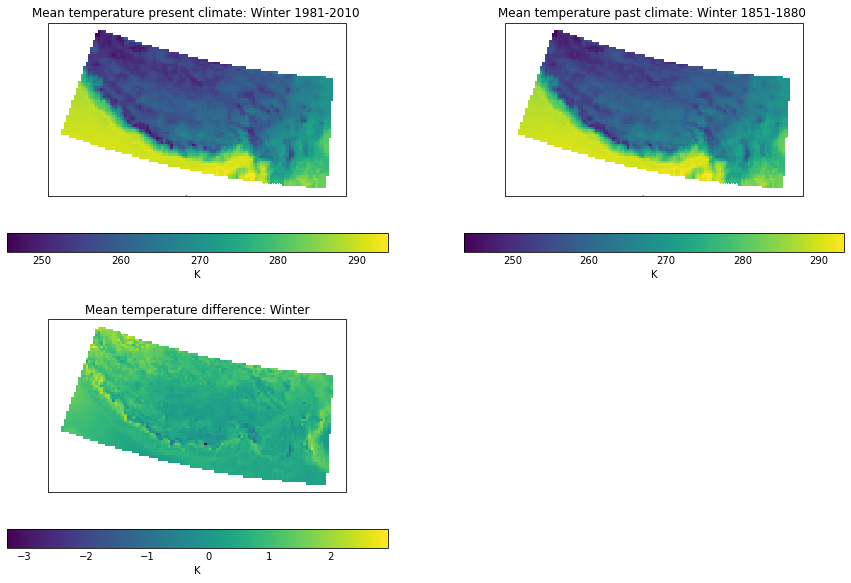

In [55]:
# visualizing the results 

# using iris plot for better colour saturation!
import iris.plot as iplt

# list of our winter cubes and the diff cube to loop through for plotting
seasonal_cubes = [present_djf, past_djf, djf_diff]
plt.figure(figsize=(15, 10))
# loop through the seaonal cube list and plot the data
for i in range(len(seasonal_cubes)):
    plt.subplot(2, 2, i+1)
    qplt.pcolormesh(seasonal_cubes[i][0,:,:])
    # add some coastlines for context
    plt.gca().coastlines()    
    # get the season name from the coordinate
    season = seasonal_cubes[i].coord('season').points[0]
    # add the name as plot's title
    plt.title(seasonal_cubes[i].name())
    
    
plt.show()

___

## 4. Exercises<a id='exercise'></a>

In this exercise we will analyse the mean air temperature from past 30 years (1851-1880) to present 30 years (1981-2010), over the Shanghai region, in all four seasons. Visualize past, present and difference in a row.

### Exercise 1: Load monthly data and constraint time and region

In [56]:
# extract air_temperature
air_temp = cubelist.extract('air_temperature')

# Extract mean temperature
cons = iris.Constraint(cube_func=lambda c: (len(c.cell_methods) > 0) and (c.cell_methods[0].method == 'mean') and c.cell_methods[0].intervals[0] == '1 hour')
atemp = air_temp.extract_strict(cons)

# extract the time contraints 
cons1 = iris.Constraint(time=lambda cell: 1851 <= cell.point.year <= 1880)
cons2 = iris.Constraint(time=lambda cell: 1981 <= cell.point.year <= 2010)
past = atemp.extract(cons1)
present = atemp.extract(cons2)

# defining Shanghai region coords
min_lat=29.0
max_lat=32.0
min_lon=118.0
max_lon=123.0

# extract the Shanghai region
past = extract_rot_cube(past, min_lat, min_lon, max_lat, max_lon)
present = extract_rot_cube(present, min_lat, min_lon, max_lat, max_lon)

# Add other dimension coordinates
past = add_time_coord_cats(past)
present = add_time_coord_cats(present)


# add bounds 
past = add_bounds(past, ['grid_latitude','grid_longitude'])
present = add_bounds(present, ['grid_latitude','grid_longitude'])

grid_latitude bounds added
grid_longitude bounds added
grid_latitude bounds added
grid_longitude bounds added


### Exercise 2: Calculate seasonal mean

In [57]:
# Extract the mean temperature data for all four season 
past_djf = past.extract(iris.Constraint(season='djf'))
present_djf = present.extract(iris.Constraint(season='djf'))

past_mam = past.extract(iris.Constraint(season='mam'))
present_mam = present.extract(iris.Constraint(season='mam'))

past_jja = past.extract(iris.Constraint(season='jja'))
present_jja = present.extract(iris.Constraint(season='jja'))

past_son = past.extract(iris.Constraint(season='son'))
present_son = present.extract(iris.Constraint(season='son'))

# calculate the means 
past_djf = past_djf.aggregated_by(['season'], iris.analysis.MEAN)
present_djf = present_djf.aggregated_by(['season'], iris.analysis.MEAN)

past_mam = past_mam.aggregated_by(['season'], iris.analysis.MEAN)
present_mam = present_mam.aggregated_by(['season'], iris.analysis.MEAN)

past_jja = past_jja.aggregated_by(['season'], iris.analysis.MEAN)
present_jja = present_jja.aggregated_by(['season'], iris.analysis.MEAN)

past_son = past_son.aggregated_by(['season'], iris.analysis.MEAN)
present_son = present_son.aggregated_by(['season'], iris.analysis.MEAN)

# Calculating the difference and renaming the cubes
djf_diff = iris.analysis.maths.subtract(present_djf, past_djf)
djf_diff.rename('Mean temperature difference: DJF')
past_djf.rename('Mean temperature past climate: DJF')
present_djf.rename('Mean temperature present climate: DJF')

mam_diff = iris.analysis.maths.subtract(present_mam, past_mam)
mam_diff.rename('Mean temperature difference: MAM')
past_mam.rename('Mean temperature past climate: MAM')
present_mam.rename('Mean temperature present climate: MAM')

jja_diff = iris.analysis.maths.subtract(present_jja, past_jja)
jja_diff.rename('Mean temperature difference: JJA')
past_jja.rename('Mean temperature past climate: JJA')
present_jja.rename('Mean temperature present climate: JJA')

son_diff = iris.analysis.maths.subtract(present_son, past_son)
son_diff.rename('Mean temperature difference: SON')
past_son.rename('Mean temperature past climate: SON')
present_son.rename('Mean temperature present climate: SON')

### Exercise 3: Visualise the results

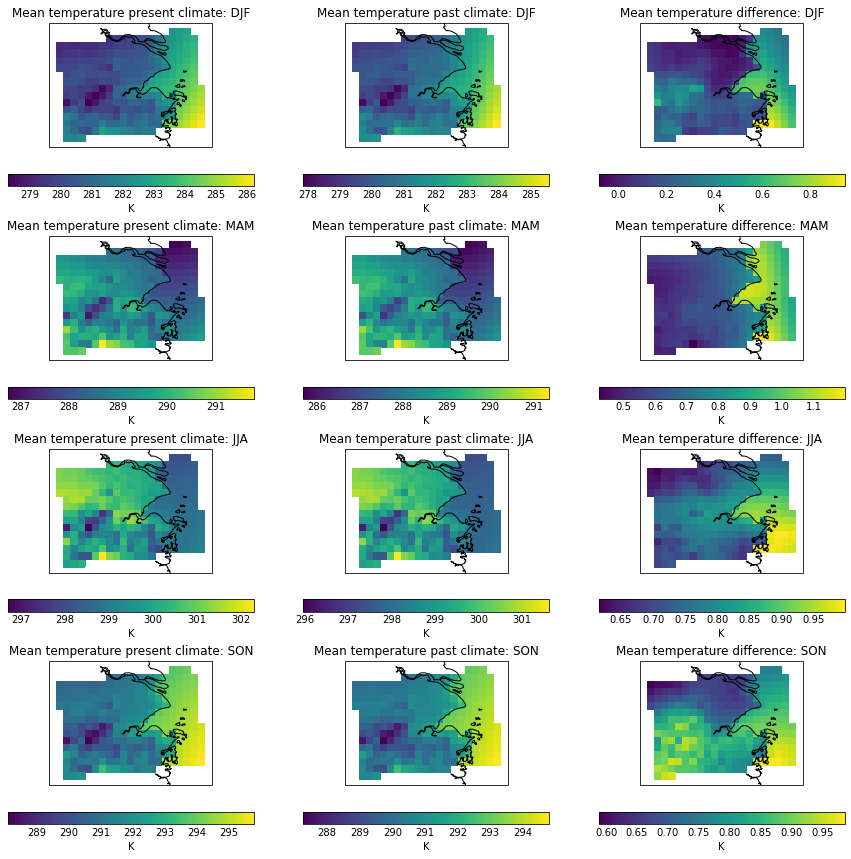

In [58]:
# visualizing the results 

# using iris plot for better colour saturation!
import iris.plot as iplt

# list of our winter cubes and the diff cube to loop through for plotting
seasonal_cubes = [present_djf, past_djf, djf_diff, present_mam, past_mam, mam_diff, present_jja, past_jja, jja_diff, present_son, past_son, son_diff]
plt.figure(figsize=(15, 15))
# loop through the seaonal cube list and plot the data
for i in range(len(seasonal_cubes)):
    plt.subplot(4, 3, i+1)
    qplt.pcolormesh(seasonal_cubes[i][0,:,:])
    # add some coastlines for context
    plt.gca().coastlines()    
    # get the season name from the coordinate
    season = seasonal_cubes[i].coord('season').points[0]
    # add the name as plot's title
    plt.title(seasonal_cubes[i].name())
    
    
plt.show()

___

<div class="alert alert-block alert-success">
<b>Summary</b><br> 
    In this session we learned how:<br>
    <ul>
        <li>to calculate yearly and monthly means</li>
        <li>to calculate seasonal means and differences</li>
        <li>to visualize the results</li>
    </ul>

</div>
